# Incorporating BBAug into Training

This notebook provides an example of how to incorporate the BBAug package into training a model.

In [1]:
# Import the packages we need
import inspect
import glob
import os

from imgaug import augmenters as iaa
import numpy as np
from PIL import Image
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

In [2]:
os.chdir('../')

In [3]:
from bbaug.policies import policies

List the policies available:

In [4]:
print(policies.list_policies())

['policies_v0', 'policies_v1', 'policies_v2', 'policies_v3']


We can see that 4 policies are available. Let's use policy version 3

In [5]:
aug_policy = policies.policies_v3()

What are the sub-policies / augmentations in this policy?

In [6]:
aug_policy

[[policy(name='Posterize', probability=0.8, magnitude=2),
  policy(name='Translate_X', probability=1.0, magnitude=8)],
 [policy(name='Cutout_Fraction', probability=0.2, magnitude=10),
  policy(name='Sharpness', probability=1.0, magnitude=8)],
 [policy(name='Rotate', probability=0.6, magnitude=8),
  policy(name='Rotate', probability=0.8, magnitude=10)],
 [policy(name='Equalize', probability=0.8, magnitude=10),
  policy(name='Auto_Contrast', probability=0.2, magnitude=10)],
 [policy(name='Solarize_Add', probability=0.2, magnitude=2),
  policy(name='Translate_Y', probability=0.2, magnitude=8)],
 [policy(name='Sharpness', probability=0.0, magnitude=2),
  policy(name='Color', probability=0.4, magnitude=8)],
 [policy(name='Equalize', probability=1.0, magnitude=8),
  policy(name='Translate_Y', probability=1.0, magnitude=8)],
 [policy(name='Posterize', probability=0.6, magnitude=2),
  policy(name='Rotate', probability=0.0, magnitude=10)],
 [policy(name='Auto_Contrast', probability=0.6, magnitu

The next step into create a policy container. This container will hold the policy set we want to use.

In [7]:
aug_policy_container = policies.PolicyContainer(aug_policy)

The policy container can take several inputs. The only required input is the policy list. You may wish to pass a custom `name_to_augmentation` mapping for you own augmentations. If that is the case please refer to the custom augmentation notebook. If the model you’re training requires the input in YOLO format set the keyword argument `return_yolo` to `True`.

In [45]:
for line in inspect.getdoc(policies.PolicyContainer.__init__).split('\n'):
    if line:
        print(line)

Policy container initialisation
:type policy_list: List[List[POLICY_TUPLE_TYPE]]
:param policy_list: List of policies available for augmentation
:type name_to_augmentation: Dict[str, Callable]
:param name_to_augmentation: Mapping of augmentation name to function
                             reference
:type return_yolo: bool
:param return_yolo: Flag for returning the bounding boxes in YOLO
                    format


Below I've created an `ExampleDataset` class which will carry out the process of loading in a single image and performing augmentation.

In [9]:
class ExampleDataset:
    
    def __init__(self, root, augmentation_policy=None):
        self.root = root
        self.augmentation_policy = augmentation_policy
        self.imgs = list(sorted(glob.glob(f'{root}/images/*.jpg')))
        self.boxes = list(sorted(glob.glob(f'{root}/boxes/*.txt')))
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.imgs)
        
    def __getitem__(self, idx):
        img = np.array(Image.open(self.imgs[idx]))
        boxes_path = self.boxes[idx]
        
        # For convenience I’ve hard coded the co-ordinates as x_min, y_min, x_max, y_max
        # for each bounding box in the image. For your own model you will need to load
        # in the coordinates and do the appropriate transformations. 
        with open(boxes_path, 'r') as in_box:
            boxes = [list(map(int, line.strip().split(' '))) for line in in_box if line]
        
        if self.augmentation_policy:

            # Select a random policy from the policy list we pass ing
            random_policy = self.augmentation_policy.select_random_policy()
            print(random_policy)

            # Apply this augmentation to the image, returns the augmented image and bounding boxes
            img_aug, bbs_aug = self.augmentation_policy.apply_augmentation(
                random_policy,
                img,
                boxes
            )
            img = self.to_tensor(img) # Convert the image to a tensor
            boxes = np.array(boxes)
            img_aug = self.to_tensor(img_aug) # Convert the augmented image to a tensor
            bbs_aug= np.array(bbs_aug)
            
            # Only return the augmented image and bounded boxes if there are
            # boxes present after the image augmentation
            if bbs_aug.size > 0:
                return img, boxes, img_aug, bbs_aug
            else:
                return img, boxes, [], np.array([])
        return img, boxes
        
    def collate_fn(self, batch):
        """
        Custom collate function to incorporate the augmentations into the 
        input tensor
        """
        if self.augmentation_policy:
            imgs, targets, imgs_aug, targets_aug = list(zip(*batch))


            # Create the image and target list for the unaugmented data
            imgs = [i for i in imgs]
            targets = [i for i in targets]

            # Only add the augmented images and targets if there are targets
            for i, box_aug in enumerate(targets_aug):
                if box_aug.size > 0:
                    imgs.append(imgs_aug[i])
                    targets.append(box_aug)

            # Stack the unaugmented and augmented images together
            imgs = torch.stack(imgs)
            
            # Concatenate the unaugmented and augmented targets together
            # also add the sample index to the first column
            for i in range(len(imgs)):
                targets[i] = torch.Tensor(np.insert(targets[i], 0, i, axis=1))
            targets = torch.cat(targets, 0)
            
            return imgs, targets

Instantiate the `ExampleDataset` class with the policy container. Then apply a sub-policy to the first image in the dataset.

In [10]:
dataset = ExampleDataset('./notebooks/data/example_dataset', augmentation_policy=aug_policy_container)
img, bbs, img_aug, bbs_aug = dataset[0]

[policy(name='Solarize_Add', probability=0.2, magnitude=2), policy(name='Translate_Y', probability=0.2, magnitude=8)]


We can see the above sub-policy was applied to the image.

Let's run it with the `DataLoader` class:

In [22]:
dataloader = DataLoader(
    dataset,
    batch_size=1,
    num_workers=0,
    collate_fn=dataset.collate_fn
)
for epoch in range(1):
    for batch in dataloader:
        images, targets = batch
        print(images.shape)
        print(targets.shape)
        
        # Put your magic here

[policy(name='Solarize_Add', probability=0.8, magnitude=6), policy(name='Equalize', probability=0.8, magnitude=8)]
torch.Size([2, 3, 333, 499])
torch.Size([4, 5])


In [23]:
targets

tensor([[  0.,  42.,  71., 266., 244.],
        [  0., 279.,  48., 341.,  71.],
        [  1.,  42.,  71., 266., 244.],
        [  1., 279.,  48., 341.,  71.]])

We now have the original image and the augmented image in a single tensor.

Showing the original and augmented image from the tensor:

In [24]:
tensor_to_image = transforms.ToPILImage()

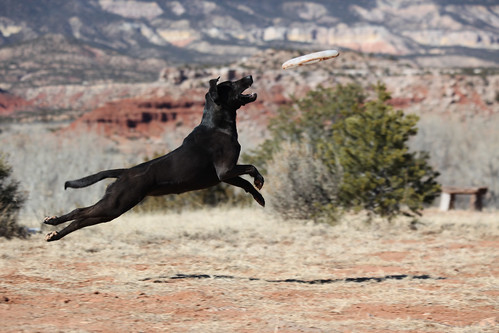

In [25]:
# Original Image
tensor_to_image(images[0])

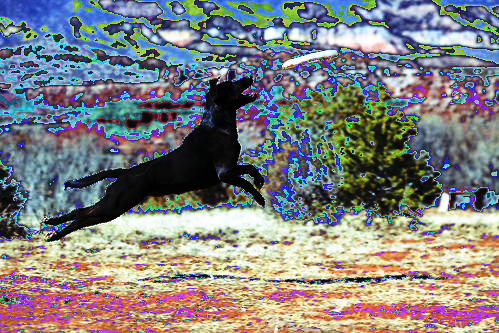

In [26]:
# Augmented Image
tensor_to_image(images[1])

## Bounding Boxes Outside the Image

In some cases augmentations can result in the bounding box falling partially or even completely outside the image. BBAug handles this by clipping those partially outside and removing those completely outside.

Create a couple of augmentations:

In [27]:
# Will push bounding boxes outside the image
def over_translate(_: int):
    return iaa.Affine(translate_px={"x": 500})

# Will do nothing
def no_translate(_: int):
    return iaa.Affine(translate_px={"x": 0})

Create a policy container with the augmentations created above. Also create a new mapping.

In [32]:
aug_policy_container = policies.PolicyContainer(
    [
        [policies.POLICY_TUPLE(name='Over_Translate', probability=1.0, magnitude=8)],
        [policies.POLICY_TUPLE(name='No_Translate', probability=1.0, magnitude=8)]
    ],
    name_to_augmentation={
        'Over_Translate': over_translate,
        'No_Translate': no_translate,
    }
)

In [37]:
dataset = ExampleDataset('./notebooks/data/example_dataset', augmentation_policy=aug_policy_container)

In [38]:
dataloader = DataLoader(
    dataset,
    batch_size=1,
    num_workers=0,
    collate_fn=dataset.collate_fn
)
for epoch in range(1):
    for batch in dataloader:
        images, targets = batch
        print(images.shape)
        print(targets.shape)

[policy(name='No_Translate', probability=1.0, magnitude=8)]
torch.Size([2, 3, 333, 499])
torch.Size([4, 5])


In [39]:
targets

tensor([[  0.,  42.,  71., 266., 244.],
        [  0., 279.,  48., 341.,  71.],
        [  1.,  42.,  71., 266., 244.],
        [  1., 279.,  48., 341.,  71.]])

We can see the `No_Translate` augmentation was applied. We have two images in the input tensor and two sets of bounding boxes in the targets. Running again:

In [42]:
for epoch in range(1):
    for batch in dataloader:
        images, targets = batch
        print(images.shape)
        print(targets.shape)

[policy(name='Over_Translate', probability=1.0, magnitude=8)]
torch.Size([1, 3, 333, 499])
torch.Size([2, 5])


In [43]:
targets

tensor([[  0.,  42.,  71., 266., 244.],
        [  0., 279.,  48., 341.,  71.]])

We now only have a single image in the tensor. This is because the `Over_Translate` augmentations was applied pushing the bounding boxes outside of the image and therefore they were removed. Proof that we keep the original image:

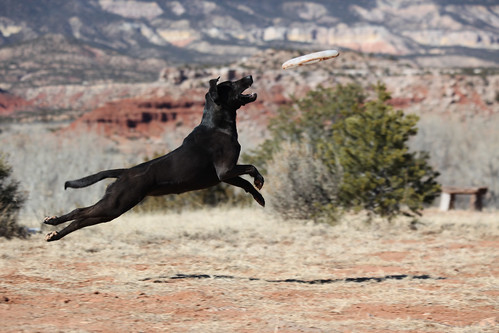

In [44]:
tensor_to_image(images[0])